# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Instantiate a rendering and a non-rendering environment.
env = gym.make('CartPole-v1')
env.reset()

(array([-0.02213944, -0.02487873,  0.02254145, -0.00770932], dtype=float32),
 {})

In [4]:
env = gym.make("CartPole-v1", render_mode="human")
obs, info = env.reset()

for _ in range(10):
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    print(obs,reward, terminated, truncated, info)
    if terminated or truncated:
        obs, info = env.reset()
       

env.close()


[-0.01440958 -0.21442223  0.00605933  0.34209707] 1.0 False False {}
[-0.01869802 -0.40962985  0.01290127  0.6366846 ] 1.0 False False {}
[-0.02689062 -0.2146902   0.02563496  0.34809226] 1.0 False False {}
[-0.03118443 -0.01994205  0.0325968   0.06360189] 1.0 False False {}
[-0.03158326  0.17469774  0.03386884 -0.21862096] 1.0 False False {}
[-0.02808931 -0.02089157  0.02949642  0.08455031] 1.0 False False {}
[-0.02850714  0.17379542  0.03118743 -0.19868246] 1.0 False False {}
[-0.02503123 -0.0217584   0.02721378  0.10367325] 1.0 False False {}
[-0.0254664  -0.21725957  0.02928725  0.40481627] 1.0 False False {}
[-0.02981159 -0.02256493  0.03738357  0.12150879] 1.0 False False {}


**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 


*   **Goal**: To create a neural network that can learn a policy for an agent. Specifically, it must take a state observation from the environment as input and produce a probability distribution over all possible actions as output.

*   **Method**:
    1.  **Inheritance**: The class inherits from `nn.Module`, the base class for all neural network modules in PyTorch.
    2.  **Initialization (`__init__`)**: The constructor takes the environment (`env`) as an argument to dynamically determine the network's input and output sizes.
        *   `obs_size`: The number of inputs to the network, determined by the shape of the environment's observation space.
        *   `action_size`: The number of outputs from the network, determined by the number of discrete actions available in the environment.
    3.  **Architecture (`nn.Sequential`)**: A simple feed-forward neural network is defined.
        *   `nn.Linear(obs_size, 128)`: A fully connected layer that takes the state observation and maps it to an intermediate representation of 128 features.
        *   `nn.ReLU()`: A non-linear activation function that allows the network to learn more complex relationships.
        *   `nn.Linear(128, action_size)`: A second fully connected layer that maps the 128 features to a raw score (logit) for each possible action.
        *   `nn.Softmax(dim=-1)`: This crucial final layer converts the raw action scores into a valid probability distribution. Each output value will be between 0 and 1, and the sum of all output values will be 1.
    4.  **Forward Pass (`forward`)**: This method defines what happens when data is passed through the network. It simply takes the input tensor `x` (representing the state) and passes it through the defined `self.net`.

*   **Result**:
    *   An instance of `PolicyNet` is a callable object that performs a clear function: when you feed it a state tensor, it outputs a tensor of probabilities.

In [5]:
class PolicyNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        obs_size = env.observation_space.shape[0]
        action_size = env.action_space.n

        self.fc1 = nn.Linear(obs_size, 128)
        self.fc2 = nn.Linear(128, action_size)
        
        self.net = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            nn.Linear(128, action_size),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.net(x)
        


*   **Goal**: To use the policy network to stochastically select a single action to perform in the environment and to compute the log-probability of that action, which is essential for the REINFORCE algorithm's learning update.

*   **Method**:
    1.  **Get Action Probabilities**: The observation `obs` is passed through the `policy` network. The network's output is a tensor of probabilities (e.g., `[0.1, 0.7, 0.1, 0.1]`), representing the likelihood of each action being the best choice.
    2.  **Create a Distribution**: Instead of just using the raw probabilities, the code creates a `torch.distributions.Categorical` object. This is a powerful PyTorch tool that encapsulates the probability distribution and provides helpful methods, like `sample()` and `log_prob()`.
    3.  **Sample an Action**: `dist.sample()` is called to draw one action from the distribution. This is the **stochastic** part of the policy. With probabilities `[0.1, 0.7, 0.1, 0.1]`, there's a 70% chance of sampling action `1`, but there's still a 30% chance of sampling one of the others. This encourages the agent to **explore** actions it isn't yet certain about.
    4.  **Calculate Log Probability**: `dist.log_prob(action)` calculates the natural logarithm of the probability of the action that was just sampled. This value is critical for training. The REINFORCE algorithm will use this log-probability to update the network's weights: if the action led to a good outcome, its log-probability will be used to increase the chances of picking it again in the future.

*   **Result**: The function returns a tuple containing two values:
    1.  **`action.item()`**: A single integer (e.g., `1`) representing the chosen action. `.item()` is used to extract the Python number from the PyTorch tensor, making it ready to be passed to the environment's `step` function.
    2.  **`dist.log_prob(action)`**: A tensor containing the log-probability of the chosen action. This value isn't used to interact with the environment; instead, it's stored in a list of `rewards` and `log_probs` to be used later during the model's training phase to calculate the loss.

In [6]:
from torch.distributions import Categorical
def select_action(policy, obs):
    if not torch.is_tensor(obs):
        obs = torch.tensor(obs, dtype=torch.float32)

    dist = Categorical(policy(obs.to(device= device)))
    action = dist.sample()
    return action.item(), dist.log_prob(action)

*   **Goal**: To transform a list of immediate rewards from an episode into a more useful list of long-term **discounted returns**. This correctly assigns credit to actions based on their future outcomes.

*   **Method**: The function efficiently calculates the returns by iterating **backwards** from the end of the episode. It computes the return `G` at each timestep `t` using the formula: `Return(t) = Reward(t) + gamma * Return(t+1)`.

*   **Result**: It returns a NumPy array where each element `returns[t]` represents the total discounted reward from that step onward. This array provides the crucial learning signal needed to train the policy network.

In [16]:
def compute_returns(rewards, gamma):
        returns = np.zeros(len(rewards))
        T =  len(rewards)
        G = 0 
        for t,reward in enumerate( reversed (rewards)):
            G = reward + gamma*G   
            returns[T-t-1] = G
        return returns


*   **Goal**: To run a single, complete episode from the starting state to a terminal state (or until `max_steps` is reached) and to record all the log probabilities, rewards, and observations encountered along the way.

*   **Method**:
    1.  **Initialization**: The function begins by resetting the environment to get the initial observation (`obs`) and creating empty lists to store the `log_probs`, `rewards`, and `observations` for the episode.
    2.  **Interaction Loop**: It enters a loop that runs for a maximum of `max_steps`.
    3.  **Action Selection**: Inside the loop, it calls the `select_action` function, passing in the current `policy` and `obs`. This uses the neural network to stochastically choose an `action` and calculate its `log_prob`.
    4.  **Data Storage**: It appends the `log_prob` and the current `obs` to their respective lists. This pairing is crucial for training, as it links an action's probability to the state it was chosen in.
    5.  **Environment Step**: The chosen `action` is sent to the environment via `env.step()`, which executes the action and returns the `next observation`, the immediate `reward`, and done flags. The received `reward` is also stored.
    6.  **Termination**: The loop checks the `terminated` or `truncated` flags. If either is `True`, the episode has ended, and the loop is broken.
    7.  **Data Aggregation**: Once the episode is over, the lists of tensors (`log_probs` and `list_obs`) are converted into single, stacked tensors using `torch.stack`. 

*   **Result**: The function returns a tuple containing three items that represent the complete trajectory of the episode:
    1.  **`log_probs`**: A single PyTorch tensor containing the log-probability of each action taken.
    2.  **`rewards`**: A standard Python list of the rewards received at each step.
    3.  **`list_obs`**: A single PyTorch tensor of every observation (state) the agent was in.
    
    This packaged "experience" contains all the information needed for the subsequent steps: calculating the discounted returns and updating the policy network's weights.

In [11]:
def run_episode(env, policy, max_steps=500):
    obs, _ = env.reset()
    list_obs = []
    log_probs, rewards = [], [], 

    for _ in range(max_steps):
        action, log_prob = select_action(policy, obs)
        log_probs.append(log_prob)
        list_obs.append(torch.from_numpy(obs))
        obs, reward, terminated, truncated, _ = env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            break
    return torch.stack(log_probs), rewards , torch.stack(list_obs) 

**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

*   **Goal**: To get a statistically robust estimate of the current policy's performance by averaging key metrics over multiple episodes, thereby reducing the noise from any single "lucky" or "unlucky" run.

*   **Method**:
    1.  **Monte Carlo Averaging**: The function runs a loop for `M=10` iterations. In each iteration, it executes a full, independent episode using the `run_episode` function with the current `policy`.
    2.  **Metric Collection**: For each episode, it calculates and stores three important metrics:
        *   **Total Discounted Return (`returns[0]`)**: This is the discounted sum of all rewards from the very first step, which is the standard measure of an episode's total performance.
        *   **Episode Length (`len(rewards)`)**: How many steps the agent survived or took to complete the task.
        *   **Total Undiscounted Reward (`sum(rewards)`)**: The simple sum of all rewards, which is an intuitive measure of success.
    3.  **Aggregation and Averaging**: After completing all `M` episodes, the lists of collected metrics are converted to PyTorch tensors, and the `.mean()` method is used to calculate the average for each metric across the 10 runs.
    4.  **History Logging**: These newly calculated average scores are appended to the `average_returns`, `average_length`, and `average_reward` lists, which are passed as arguments. This allows the main training loop to keep a history of performance over time.
    5.  **Reporting**: A formatted string is printed to the console, providing a real-time update on the agent's performance for the current training `episode`.

*   **Result**:
    *   **Side Effect**: A status line is printed to the console, giving the user immediate feedback on the agent's current skill level.
    *   **Return Value**: The function returns the three updated history lists. These lists contain the full performance history of the agent, which can be used later to plot learning curves and visualize the agent's improvement over the course of training.

In [14]:

def eval_model(average_returns, average_length, average_reward, episode=0):
    M = 10
    tot_length, tot_returns, tot_reward = [], [], []
    for i in range(M):
        _, rewards, _ = run_episode(env, policy)
        returns = compute_returns(rewards, gamma=0.99)
        tot_returns.append(returns[0])
        tot_length.append(len(rewards))
        tot_reward.append(sum(rewards))

    tot_returns = torch.tensor(tot_returns, dtype=torch.float32)
    tot_length = torch.tensor(tot_length, dtype=torch.float32)
    tot_reward = torch.tensor(tot_reward, dtype=torch.float32)
    average_reward.append(tot_reward.mean().item())
    average_returns.append(tot_returns.mean().item())
    average_length.append(tot_length.mean().item())
    print(
        f"Episode {episode} | Average Return: {float(average_returns[-1]):.2f}, Average Length: {float(average_length[-1]):.2f}, Average Reward: {float(average_reward[-1]):.2f}")
    return average_returns, average_length, average_reward


*   **Goal**: To train the `policy` network to maximize the cumulative discounted rewards it receives from the `env`. The function's purpose is to iteratively adjust the network's parameters so that it becomes more likely to select actions that lead to good long-term outcomes.

*   **Method**: The function implements the REINFORCE algorithm through a main loop that runs for `num_episodes`. Each iteration of this loop represents one full cycle of **acting, evaluating, and learning**.

    1.  **Data Collection (Acting)**: The `run_episode(env, policy)` function is called. This function lets the agent interact with the environment for one full episode, from the starting state to a terminal state. It uses the current `policy` to `select_action` at each step and records the `log_probs` of the actions taken and the `rewards` received.

    2.  **Credit Assignment (Evaluating)**: The list of raw `rewards` is processed by `compute_returns(rewards, gamma)`. This converts the immediate, short-sighted rewards into a more meaningful list of long-term **discounted returns**. This step is crucial for assigning proper credit to each action based on its future consequences.

    3.  **Advantage Normalization (Optional but important)**: If `normalize=True`, the returns are standardized by subtracting their mean and dividing by their standard deviation. 
    4.  **Loss Calculation (The REINFORCE Update Rule)**: The core of the algorithm is the loss function: `loss = -(log_probs * returns).mean()`.
        *   `log_probs * returns`: Each action's log-probability is multiplied by the discounted return that followed it. This scales the log-probability by how "good" the outcome was.
        *   **The Intuition**:
            *   If `returns` is high and positive (a better-than-average outcome), the `log_probs` term is pushed to be larger, making that action **more likely** in the future.
            *   If `returns` is low and negative (a worse-than-average outcome), the `log_probs` term is pushed to be smaller (more negative), making that action **less likely** in the future.
        *   The negative sign (`-`) is there because optimizers in PyTorch *minimize* loss. By minimizing the negative of our objective, we are effectively *maximizing* the probability of good actions.

    5.  **Policy Update (Learning)**: Standard PyTorch backpropagation is performed. `loss.backward()` computes the gradients, and `optimizer.step()` updates the weights of the `policy` network based on those gradients.
 
    6.   **Early Stopping Logic** The key to this mechanism is the check performed during the periodic evaluation:
    *   **Condition**: `if average_length[-1] == 500:`
    *   **Meaning**: In the `CartPole-v1` environment, an episode length of 500 is the maximum possible. If the agent achieves an *average* length of 500 over the evaluation window, it means it is consistently balancing the pole perfectly without failing.
    *   **Action**: If the condition is met, a `break` statement is executed, immediately terminating the main training loop. This prevents the algorithm from running for thousands of unnecessary episodes after the problem has already been mastered.
 

*   **Result**:
    *   The primary result is that the input `policy` network is **trained**. After hundreds or thousands of episodes, its parameters are adjusted so that it produces a much better strategy for playing the game than when it started.
    *   The function also returns several lists (`running_rewards`, `average_returns`, etc.) that serve as logs of the training process. These can be used to plot learning curves to visualize whether the agent successfully improved its performance over time.

In [13]:

def reinforce(policy, env, gamma=0.99, num_episodes=1000, lr=1e-2, n_eval=100, normalize=True):
    policy.to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    running_rewards = [0.0]
    average_returns, average_length, average_rewards = eval_model([], [], [])
    policy.train()
    for episode in range(num_episodes):
        log_probs, rewards, _ = run_episode(env, policy)

        returns = torch.tensor(compute_returns(rewards, gamma))

        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        if normalize:
            returns = (returns - returns.mean()) / returns.std()
        returns = returns.to(device)
        loss = -(log_probs * returns).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Rendering every n_eval episodes
        if episode % n_eval == 0 and episode > 0:
            average_returns, average_length, average_rewards = eval_model(average_returns, average_length, average_rewards, episode)
            if average_length[-1] == 500:
                print(f"Episode {episode} solved with average reward: {average_rewards[-1]:.2f}")
                num_episodes = episode
                break

    average_returns, average_length, average_rewards = eval_model(average_returns, average_length, average_rewards, num_episodes)
    policy.eval()
    return running_rewards, average_returns, average_length, average_rewards



*   **Goal**: To run the full REINFORCE experiment: training a policy network to solve the `CartPole-v1` environment and then visualizing its learning progress.

*   **Method**:
    1.  **Setup**: The script initializes the environment (`CartPole-v1`) and the `PolicyNet`. It also sets random seeds for reproducibility.
    2.  **Training**: It calls the `reinforce` function, which runs the main training loop, updating the policy network's weights based on experience from hundreds of episodes.
    3.  **Visualization**: After training is complete, it uses `matplotlib` to plot the performance metrics (like average episode length and rewards) that were logged during the training process.

*   **Result**:
    1.  A **trained `policy` network** that has learned a successful strategy for balancing the pole.
    2.  A set of **performance plots** that visually confirm the agent's improvement over time, with the episode length ideally reaching the maximum possible value.

Using device: cuda
Episode 0 | Average Return: 23.40, Average Length: 27.90, Average Reward: 27.90
Episode 100 | Average Return: 98.66, Average Length: 459.90, Average Reward: 459.90
Episode 200 | Average Return: 62.88, Average Length: 99.50, Average Reward: 99.50
Episode 300 | Average Return: 95.71, Average Length: 324.00, Average Reward: 324.00
Episode 400 | Average Return: 99.34, Average Length: 500.00, Average Reward: 500.00
Episode 400 solved with average reward: 500.00
Episode 400 | Average Return: 99.34, Average Length: 500.00, Average Reward: 500.00


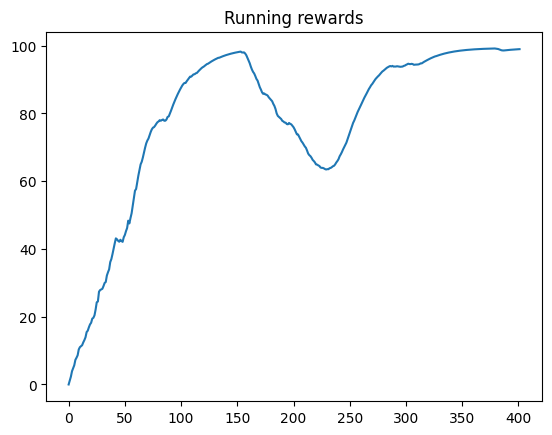

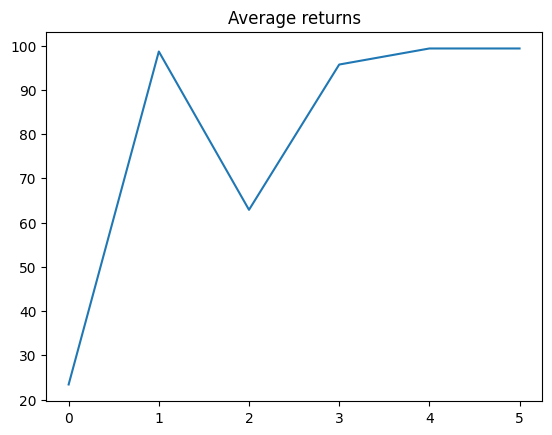

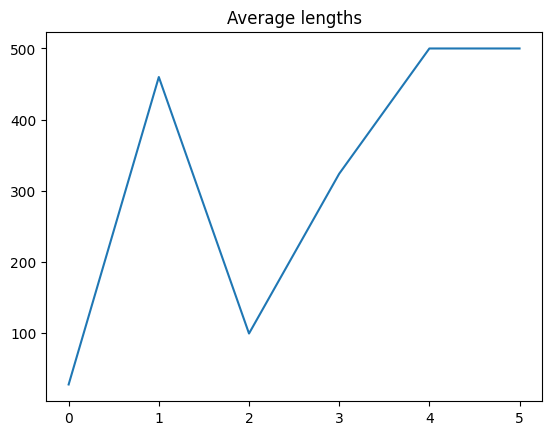

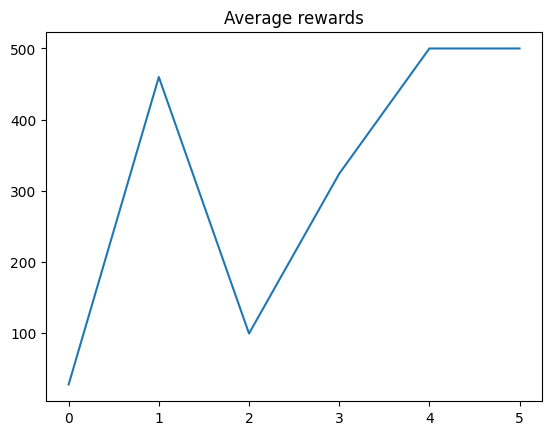

In [23]:
import numpy as np
import matplotlib.pyplot as plt
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
env = gym.make('CartPole-v1')
env.reset(seed=seed)

# Make a policy network.
policy = PolicyNet(env)

# Train the agent.
rr, av_returns , al, av_rewards = reinforce(policy, env, 0.99, num_episodes=1000, n_eval = 100)

plt.plot(rr)
plt.title("Running rewards")
plt.show()

plt.plot(av_returns)
plt.title("Average returns")
plt.show()

plt.plot(al)
plt.title("Average lengths")
plt.show()


plt.plot(av_rewards)
plt.title("Average rewards")
plt.show()

env.close()

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 


#### Goal
To create a neural network that learns the **state-value function (V(s))**. It takes a state as input and outputs a single number estimating the total discounted reward the agent can expect to receive from that point forward.

#### Method
The `ValueNet` uses an architecture that is nearly identical to the `PolicyNet`, but with two crucial changes that are directly related to its different purpose:

1.  **Change**: The final linear layer (`fc2`) outputs a single, scalar value (`nn.Linear(128, 1)`), not a vector of scores for each action.
    *   **Reason**: The network's job is to predict a single quantity—the "value" of the current state—not to score different possible actions.

2.  **Change**: The final `nn.Softmax` activation function is removed. The network outputs the raw, unconstrained value from its final neuron.
    *   **Reason**: The value of a state is not a probability and does not need to be between 0 and 1. It is a real number representing the expected cumulative reward, which can be positive, negative, large, or small. A Softmax function would incorrectly force the output into a probability distribution.

#### Result
The `ValueNet` instance is a callable object that maps a state observation to a single numerical value. This value is the network's current **prediction of how good that state is**. In an Actor-Critic algorithm, this prediction acts as a baseline. It is compared against the actual return to calculate a more effective learning signal called the **Advantage**, which is then used to train the `PolicyNet`.

In [19]:
class ValueNet(nn.Module):
    def __init__(self, env):
        super().__init__()
        obs_size = env.observation_space.shape[0]
        self.fc1 = nn.Linear(obs_size, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

#### Goal
To train the `policy` network using the guidance of the `value` network . The Value network role is to learn the value of states, which allows the policy to learn based on whether an outcome was **better or worse than expected**, rather than just whether it was good or bad in an absolute sense.

#### Method
The function's main loop orchestrates a two-part update cycle within each episode, following the Actor-Critic paradigm:

1.  **Setup**: Two separate optimizers are created, `opt_policy` for the Actor and `opt_value` for the Critic. This is because they are two distinct networks being trained on different objectives.

2.  **Experience Collection**: As before, `run_episode` is called to have the agent interact with the environment, collecting `log_probs`, `rewards`, and the sequence of `obs` (states).

3.  **Calculate Targets and Predictions**: After the episode, two crucial quantities are determined:
    *   **The Target (`returns`)**: The `compute_returns` function calculates the *actual* discounted return for each step. This is the "ground truth" of what happened.
    *   **The Prediction (`value_output`)**: The `value` network  is fed the entire sequence of states (`obs`) from the episode. Its output is its *prediction* of the value for each of those states.

4.  **Calculate the Advantage**: This is the core of the baseline method. The **Advantage** is calculated as: `advantage = returns - value_output`.
    *   **Intuition**: The Advantage answers the question: "For this state, was the actual outcome better or worse than I expected it to be?"
    *   If `advantage` is positive, the outcome was better than expected.
    *   If `advantage` is negative, the outcome was worse than expected.
    *   This is a much more powerful learning signal than raw `returns`. An action leading to a high return might not have been good if an even higher return was expected. Conversely, an action leading to a small negative return might have been excellent if the situation was terrible and a large negative return was expected.
    *   Crucially, `value_output.detach()` is used to stop gradients from flowing from the policy's loss back into the value network. The two networks must be trained on their separate objectives.

5.  **The Two-Part Update**:
    *   **Critic Update**: The `value` network is trained first. Its goal is to become a better predictor. The loss is calculated using Mean Squared Error (`loss_value = loss_f(value_output, returns)`), which directly measures the error between its predictions and the actual returns. It's a standard supervised learning update.
    *   **Actor Update**: The `policy` network is then trained. The loss function is almost identical to the standard REINFORCE algorithm, but the noisy `returns` are replaced with the much more stable `advantage`: `loss_policy = - (log_probs * advantage).mean()`.

#### Result
*   The function trains both the `policy`  and `value` networks simultaneously.
*   The key outcome is **more stable and reliable training**. By learning from the `advantage` instead of the raw `returns`, the policy update is less susceptible to high variance, which often a problem for the simpler REINFORCE algorithm.
*   The returned logs (`running_rewards`, etc.) can be plotted to show the agent's learning progress, which is typically smoother and faster than without the baseline.

In [20]:


# Reinforce + baseline con supporto GPU
def reinforce_baseline(policy, value, env, gamma=0.99, num_episodes=2000, lr_policy=1e-2, lr_value=1e-2, n_eval=100,
                       normalize=False):
    # sposto modelli su device
    policy.to(device)
    value.to(device)

    opt_policy = torch.optim.Adam(policy.parameters(), lr=lr_policy)
    opt_value = torch.optim.Adam(value.parameters(), lr=lr_value)
    loss_f = torch.nn.MSELoss()

    running_rewards = [0.0]
    average_returns, average_length, average_rewards = eval_model([], [], [])  # keep as your original call
    policy.train();
    value.train()

    for episode in range(num_episodes):
        log_probs, rewards, obs = run_episode(env,
                                              policy)  # assume: log_probs is list of tensor scalars, obs list of states

        # convert observations -> tensor e sposto su device
        obs = obs.to(device=device)  # [T, obs_dim]

        # returns: compute_returns può ritornare lista/np.array
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32, device=device)  # [T]

        # running reward (usa R0 che è returns[0])
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])

        # forward value (già su device)
        value_output = value(obs).squeeze()  # -> [T] (o scalar)
        if value_output.dim() == 0:
            value_output = value_output.unsqueeze(0)

        # log_probs: se è lista di tensori, trasformala in tensore e spostalo su device
        # Assumo che ogni elemento di log_probs sia un tensore scalar (es. torch.tensor(-0.23))
        if isinstance(log_probs, list):
            log_probs = torch.stack(log_probs).to(device)  # -> [T]
        else:
            log_probs = log_probs.to(device)

        # advantage (detach value so policy update doesn't flow into value net)
        advantage = returns - value_output.detach()
        if normalize:
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        # 1) update value network
        opt_value.zero_grad()
        loss_value = loss_f(value_output, returns)
        loss_value.backward()
        opt_value.step()

        # 2) update policy network
        opt_policy.zero_grad()
        # assicurati che log_probs e advantage abbiano la stessa shape
        loss_policy = - (log_probs * advantage).mean()
        loss_policy.backward()
        opt_policy.step()

        # optional eval
        if episode % n_eval == 0 and episode > 0:
            average_returns, average_length, average_rewards = eval_model(average_returns, average_length,average_rewards, episode)

            if average_length[-1] == 500:
                print(f"Episode {episode} solved with average reward: {average_rewards[-1]:.2f}")
                num_episodes = episode
                break
    average_returns, average_length, average_rewards = eval_model(average_returns, average_length, average_rewards, num_episodes)
    return running_rewards, average_returns, average_length, average_rewards




Using device: cuda
Episode 0 | Average Return: 18.93, Average Length: 21.20, Average Reward: 21.20
Episode 100 | Average Return: 95.30, Average Length: 434.20, Average Reward: 434.20
Episode 200 | Average Return: 99.34, Average Length: 500.00, Average Reward: 500.00
Episode 200 solved with average reward: 500.00
Episode 200 | Average Return: 99.34, Average Length: 500.00, Average Reward: 500.00


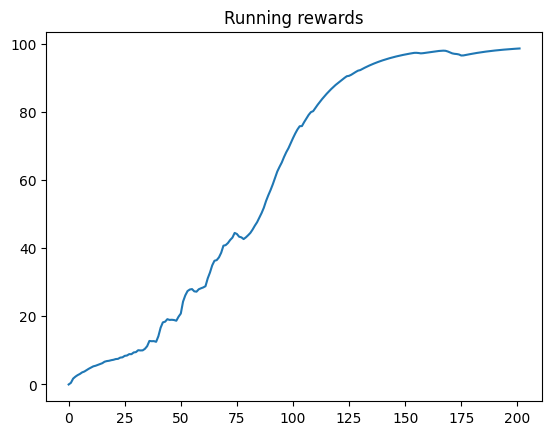

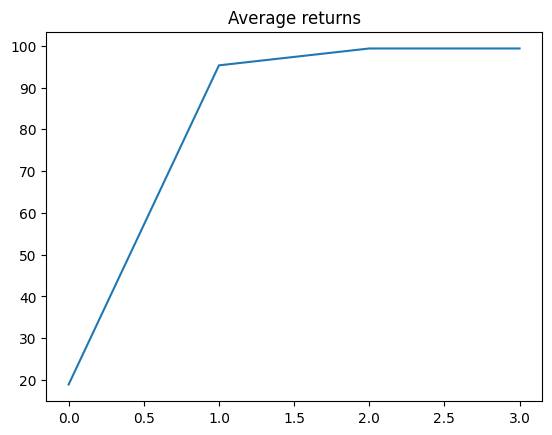

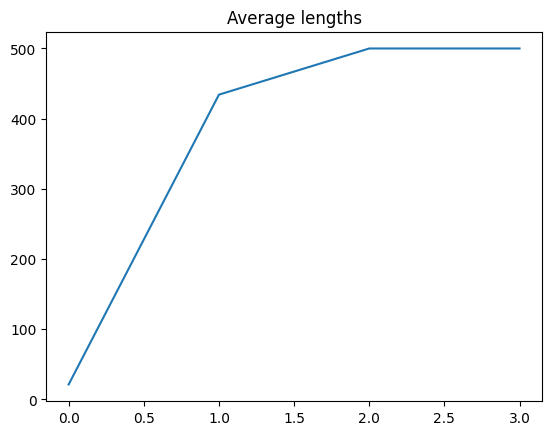

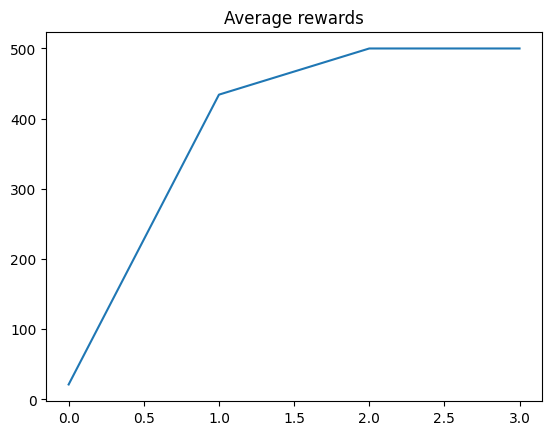

In [25]:
env = gym.make('CartPole-v1')
env.reset(seed=seed)

policy = PolicyNet(env)   # la tua PolicyNet
value = ValueNet(env)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
# NOTA: i modelli verranno spostati su device dentro la funzione reinforce_baseline
rr, av_return , al ,av_rewards = reinforce_baseline(policy, value, env, 0.99, num_episodes=2000, n_eval=100)



plt.plot(rr)
plt.title("Running rewards")
plt.show()

plt.plot(av_return)
plt.title("Average returns")
plt.show()

plt.plot(al)
plt.title("Average lengths")
plt.show()


plt.plot(av_rewards)
plt.title("Average rewards")
plt.show()


This code sets up a systematic experiment to robustly evaluate and compare the performance of three different Reinforcement Learning training strategies on the `CartPole-v1` environment. The core of this experiment is a **Monte Carlo simulation**, which involves running the entire training process multiple times (`montecarlo = 10`) for each algorithm and aggregating the results. This is a critical methodology in Reinforcement Learning because the training process is highly **stochastic** (random). The initial weights of the network, the agent's exploratory actions, and the environment's responses can all vary, meaning a single training run might be unusually good or bad due to luck. By averaging the results over 10 independent trials, we can smooth out this randomness and get a much more reliable estimate of each algorithm's true performance.

The experiment compares the following three distinct training algorithms:

1.  **REINFORCE with Baseline (`reinforce_baseline`)**: An Actor-Critic method that uses a `ValueNet` to provide a baseline, which stabilizes training by reducing variance.
2.  **REINFORCE with Normalization (`reinforce`, `normalize=True`)**: The standard REINFORCE algorithm, but with a crucial enhancement where the returns are normalized. This is a common technique to stabilize the learning signal.
3.  **Standard REINFORCE (`reinforce`, `normalize=False`)**: The most basic version of the REINFORCE algorithm, which can be prone to high variance and instability.

For each of the 10 Monte Carlo runs, the script re-initializes fresh `PolicyNet` and `ValueNet` models from scratch before training. After each training process is complete, it extracts key performance metrics to evaluate the algorithm:
#### Performance Parameters Being Evaluated

*   **Peak Performance (`returns`, `reward`)**: The code doesn't just care about the final performance, but the *best* performance achieved at any point during training (`max(ar)`). This captures the maximum potential of an algorithm.
*   **Learning Speed  (`velocity`)**: It measures *how quickly* an agent solved the environment. It does this by finding the index of the first time the agent achieved the maximum possible average episode length (500). A lower value in the `velocity` list is better, as it indicates the agent learned the optimal policy in fewer training episodes. If an agent fails to solve the environment within the given 2000 episodes, it's assigned a default high value.

At the end of the 10 runs, the script stores these collected metrics in separate lists for each of the three algorithms. 

In [26]:
montecarlo = 10
seed = 10

velocity_base= []
returns_base = []
reward_base = []

velocity = []
returns = []
reward = []

returns_norm = []
velocity_norm= []
reward_norm = []

env = gym.make('CartPole-v1')
env.reset(seed=seed)
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

device = torch.device('cpu')
print("Using device:", device)
for i in range(montecarlo):
    policy = PolicyNet(env)
    value = ValueNet(env)
    print(f"Monte Carlo { i +1}/{montecarlo} - Baseline")
    _ , ar_base , al_base, out_reward_base = reinforce_baseline(policy, value, env, 0.99, num_episodes=2000, n_eval = 100)
    policy = PolicyNet(env)
    print("------------------------------------------------------------\n\n")
    print(f"Monte Carlo { i +1}/{montecarlo} - Normalized Returns")
    _ , ar_norm , al_norm, out_reward_norm = reinforce(policy, env, 0.99, num_episodes=2000, n_eval = 100)
    policy = PolicyNet(env)
    print("------------------------------------------------------------\n\n")
    print(f"Monte Carlo { i +1}/{montecarlo} - No Normalized Returns")
    _ , ar , al, out_reward = reinforce(policy, env, 0.99, num_episodes=2000, n_eval = 100, normalize=False)
    print("------------------------------------------------------------\n\n")

    max_ar_base = max(ar_base)
    returns_base.append(max_ar_base)
    max_al_base = max(al_base)
    reward_base.append(max(out_reward_base))


    max_ar = max(ar)
    returns.append(max_ar)
    max_al = max(al)
    reward.append(max(out_reward))


    max_ar_norm = max(ar_norm)
    returns_norm.append(max_ar_norm)
    max_al_norm = max(al_norm)
    reward_norm.append(max(out_reward_norm))
    
    if max_al == 500:
        velocity.append(al.index(max_al))
    else:
        velocity.append(20)

    if max_al_norm == 500 :
        velocity_norm.append(al_norm.index(max_al_norm))
    else:
        velocity_norm.append(20)


    if max_al_base == 500:
        velocity_base.append(al_base.index(max_al_base))
    else:
        velocity_base.append(20)

velocity = torch.tensor(velocity, dtype=torch.float32)
returns = torch.tensor(returns, dtype=torch.float32)
reward = torch.tensor(reward, dtype=torch.float32)

returns_norm = torch.tensor(returns_norm, dtype=torch.float32)
velocity_norm = torch.tensor(velocity_norm, dtype=torch.float32)
reward_norm = torch.tensor(reward_norm, dtype=torch.float32)


velocity_base = torch.tensor(velocity_base, dtype=torch.float32)
returns_base = torch.tensor(returns_base, dtype=torch.float32)
reward_base = torch.tensor(reward_base, dtype=torch.float32)

Using device: cpu
Monte Carlo 1/10 - Baseline
Episode 0 | Average Return: 22.27, Average Length: 26.30, Average Reward: 26.30
Episode 100 | Average Return: 86.49, Average Length: 225.30, Average Reward: 225.30
Episode 200 | Average Return: 99.34, Average Length: 500.00, Average Reward: 500.00
Episode 200 solved with average reward: 500.00
Episode 200 | Average Return: 99.34, Average Length: 500.00, Average Reward: 500.00
------------------------------------------------------------


Monte Carlo 1/10 - Normalized Returns
Episode 0 | Average Return: 17.70, Average Length: 19.80, Average Reward: 19.80
Episode 100 | Average Return: 78.82, Average Length: 155.40, Average Reward: 155.40
Episode 200 | Average Return: 99.34, Average Length: 500.00, Average Reward: 500.00
Episode 200 solved with average reward: 500.00
Episode 200 | Average Return: 99.34, Average Length: 500.00, Average Reward: 500.00
------------------------------------------------------------


Monte Carlo 1/10 - No Normalized

In [27]:



mean_velocity = velocity.mean().item()*100
mean_velocity_norm = velocity_norm.mean().item()*100
mean_velocity_base = velocity_base.mean().item()*100
  
mean_returns = returns.mean().item()
mean_returns_norm = returns_norm.mean().item()
mean_returns_base = returns_base.mean().item()

mean_reward = reward.mean().item()
mean_reward_norm = reward_norm.mean().item()
mean_reward_base = reward_base.mean().item()

print("\n=== Mean Values ===")
print(f"{'Metric':<20} {'No Norm':>12} {'Normalized':>12} {'Base':>12}")
print("-" * 60)
print(f"{'Episode to converge':<20} {mean_velocity:>12.3f} {mean_velocity_norm:>12.3f} {mean_velocity_base:>12.3f}")
print(f"{'Average Returns':<20} {mean_returns:>12.3f} {mean_returns_norm:>12.3f} {mean_returns_base:>12.3f}")
print(f"{'Average Reward':<20} {mean_reward:>12.3f} {mean_reward_norm:>12.3f} {mean_reward_base:>12.3f}")
print("=" * 60)





=== Mean Values ===
Metric                    No Norm   Normalized         Base
------------------------------------------------------------
Episode to converge      1440.000      460.000      270.000
Average Returns            79.639       94.350       99.343
Average Reward            336.120      457.020      500.000


## RESULTS
These results clearly demonstrate a strong hierarchy of performance, highlighting the critical importance of **variance reduction** in policy gradient methods.

*   **Standard REINFORCE (`No Norm`)**: This basic approach is shown to be highly inefficient. It learns very slowly and fails to achieve a high level of performance. This indicates that its learning signal, based on raw, unprocessed returns, is too noisy and unreliable for the agent to learn effectively.

*   **REINFORCE with Normalization (`Normalized`)**: By simply adding the step of normalizing the returns, we see a dramatic improvement in both learning speed and final performance. The agent learns a strong policy significantly faster. This shows that providing a more stable signal is a highly effective technique for improving the training process.

*   **REINFORCE with Baseline (`Base`)**: This Actor-Critic method emerges as the superior approach. It learns substantially faster than even the normalized version and converges to a consistently optimal policy. By using a learned value function as a baseline, it creates the most sophisticated and lowest-variance learning signal (the Advantage). This allows the agent to understand not just if an outcome was better than average, but if it was better than *expected for that specific state*, leading to the most rapid and robust learning.

In essence, the experiment shows a clear progression: while the basic algorithm struggles, each subsequent improvement in reducing the variance of the learning signal yields significant gains in both learning speed and the quality of the final policy.

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 

In [3]:
import DQL
import gymnasium as gym
import torch
render_env = gym.make("CarRacing-v3", continuous=False, render_mode="human", max_episode_steps=1500)
# render_env = DQL.StayOnTrack(render_env, 
#                                       off_track_penalty= DQL.OFF_TRACK_PENALTY, 
#                                       on_track_reward= DQL.ON_TRACK_REWARD, )
render_env = gym.wrappers.GrayscaleObservation(render_env, keep_dim=False)
render_env = DQL.CropObservation(render_env)
render_env = gym.wrappers.FrameStackObservation(render_env, stack_size=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "dqn/best_dqn_car_racing_2025-08-21_21-41-51.pth"
agent = DQL.DQNAgent(render_env)
agent.q_net.load_state_dict(torch.load(best_model_path, map_location=device))
agent.q_net.to(device)
agent.q_net.eval()

for i in range (5):
    state, _ = render_env.reset(seed=42)
    state = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
    episode_reward = 0
    n_step = 0
    while True:
        n_step += 1
        action = agent.select_action(state)[0].item()
        next_state, reward, done, truncated, _ = render_env.step(action)
        # print(n_step, 
        #       "step, action:", action, 
        #       "reward:",round(episode_reward, 3), "+", round(reward, 3), 
        #       "done:", done,
        #       "truncated:", truncated)
        episode_reward += reward
        state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)
    
        if done or truncated:
            break
    
    render_env.close()
    print(f"Reward at the end: {episode_reward:.2f}")


C:\Users\bruno\PycharmProjects\DLA\.venv\lib\site-packages\gymnasium\envs\registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='None' that is not in the possible render_modes (['human', 'rgb_array', 'state_pixels']).
  logger.warn(


Reward at the end: 842.93
Reward at the end: 842.93
Reward at the end: 842.93
Reward at the end: 842.93
Reward at the end: 842.93


In [1]:
import Lab2.DQL as DQL
import gymnasium as gym
import torch
import os
import random
import numpy as np
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

render_env = gym.make("CarRacing-v3", continuous=False, render_mode="human", max_episode_steps=1500,)
render_env = gym.wrappers.GrayscaleObservation(render_env, keep_dim=False)
render_env = DQL.CropObservation(render_env)
render_env = gym.wrappers.FrameStackObservation(render_env, stack_size=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "./dqn/best_dqn_car_racing_2025-09-02_02-21-26.pth"
agent = DQL.DQNAgent(render_env)
agent.q_net.load_state_dict(torch.load(best_model_path, map_location=device))
agent.q_net.to(device)
agent.q_net.eval()

           

state, _ = render_env.reset()
state = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
episode_reward = 0
n_step = 0
while True:
    n_step += 1
    action = agent.select_action(state)[0].item()
    next_state, reward, done, truncated, _ = render_env.step(action)
    print(n_step, 
          "step, action:", action, 
          "reward:",round(episode_reward, 3), "+", round(reward, 3), 
          "done:", done,
          "truncated:", truncated)
    episode_reward += reward
    state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

    if done or truncated:
        break

render_env.close()
print(f"Reward at the end: {episode_reward:.2f}")


1 step, action: 2 reward: 0 + 6.436 done: False truncated: False
2 step, action: 0 reward: 6.436 + -0.1 done: False truncated: False
3 step, action: 0 reward: 6.336 + -0.1 done: False truncated: False
4 step, action: 3 reward: 6.236 + -0.1 done: False truncated: False
5 step, action: 2 reward: 6.136 + -0.1 done: False truncated: False
6 step, action: 4 reward: 6.036 + -0.1 done: False truncated: False
7 step, action: 2 reward: 5.936 + -0.1 done: False truncated: False
8 step, action: 0 reward: 5.836 + -0.1 done: False truncated: False
9 step, action: 3 reward: 5.736 + -0.1 done: False truncated: False
10 step, action: 3 reward: 5.636 + -0.1 done: False truncated: False
11 step, action: 3 reward: 5.536 + -0.1 done: False truncated: False
12 step, action: 3 reward: 5.436 + -0.1 done: False truncated: False
13 step, action: 3 reward: 5.336 + -0.1 done: False truncated: False
14 step, action: 3 reward: 5.236 + -0.1 done: False truncated: False
15 step, action: 3 reward: 5.136 + -0.1 done: 